In [90]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tf
import seaborn as sns

In [91]:
bag = rosbag.Bag('/home/uware/rosbags/dynamic/rotational/roll/3m/25h9.bag')

# create variables
target = 'is_detected'

# we are interested if tag is detected at 90°/s

In [92]:
topic = '/tag_detections'

rows = []
false_positives = []

# z distance to make sure its not fp
range = (2.7, 3.3)

for topic, msg, t in bag.read_messages(topics=topic):
    time = t
    is_detected = len(msg.detections)

    if is_detected==1:
        position = msg.detections[0].pose.pose.pose.position
        if range[0] < position.z < range[1]:
            orientation_quat = msg.detections[0].pose.pose.pose.orientation
            pitch, yaw, roll = tf.transformations.euler_from_quaternion([orientation_quat.x,orientation_quat.y,orientation_quat.z,orientation_quat.w], axes='rxyz')
            row={'time': time.to_sec(), target: is_detected, 'roll': np.degrees(roll), 'pitch': np.degrees(pitch), 'yaw': np.degrees(yaw)}

        else:
            false_positives.append(msg.detections[0])

    elif is_detected>1:
        for detection in msg.detections:
            position = detection.pose.pose.pose.position
            if range[0] < position.z < range[1]:
                orientation_quat = detection.pose.pose.pose.orientation
                pitch, yaw, roll = tf.transformations.euler_from_quaternion([orientation_quat.x,orientation_quat.y,orientation_quat.z,orientation_quat.w], axes='rxyz')
                row={'time': time.to_sec(), target: 1, 'roll': np.degrees(roll), 'pitch': np.degrees(pitch), 'yaw': np.degrees(yaw)}
            else:
                false_positives.append(detection)
                
    elif is_detected==0:
        row={'time': time.to_sec(), target: is_detected, 'roll': None, 'pitch': None, 'yaw': None}
    rows.append(row)

df = pd.DataFrame.from_records(rows)
print(len(false_positives))


0


In [93]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df.groupby(target).head(2)

,is_detected,roll,pitch,yaw,relative_time
0,1,-144.940783,-176.135459,5.693327,0.000000
1,1,-179.678856,172.090866,0.061894,0.830927


In [94]:
df.roll.describe()

count    167.000000
mean      -5.117585
std      158.585659
min     -179.878788
25%     -158.751883
50%     -141.160233
75%      151.828521
max      179.646551
Name: roll, dtype: float64

In [95]:
df.roll = df.roll.apply(lambda x: x + 180 if x < 0 else x - 180)

In [96]:
df.roll.max() - df.roll.min()

80.8300147442682

In [97]:
# ratio of detected to not
ratios = df.is_detected.value_counts(normalize=True)*100
ratios

1    100.0
Name: is_detected, dtype: float64

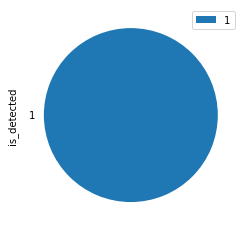

In [98]:
ratios.plot.pie()
plt.legend()

In [99]:
df.head(5)

,is_detected,roll,pitch,yaw,relative_time
0,1,35.059217,-176.135459,5.693327,0.000000
1,1,0.321144,172.090866,0.061894,0.830927
2,1,-33.341637,-175.763106,4.298778,1.620032
3,1,17.310363,170.949020,3.919666,2.456380
4,1,-13.393996,172.902571,7.311995,3.368556


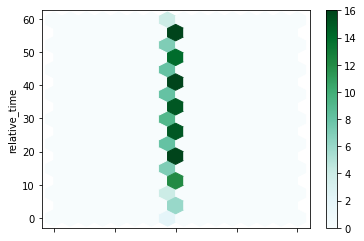

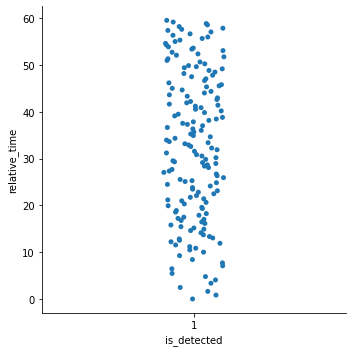

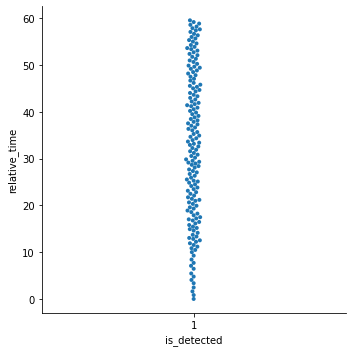

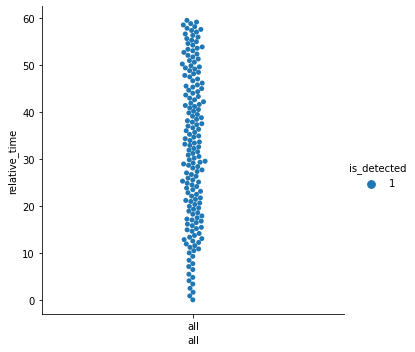

In [100]:
df.plot.hexbin(x=target, y="relative_time", gridsize=15)
sns.catplot(x=target, y='relative_time', data=df)
sns.catplot(x=target, y='relative_time', data=df, kind="swarm", s=4) # s=size of markers causes warnings when >4

# creating a dummy column for plotting both classes together
df.loc[:,'all'] = 'all'
sns.catplot(x='all', y='relative_time', data=df, hue=target, kind="swarm")

In [101]:
df.roll.describe()

count    167.000000
mean      -1.884052
std       25.880388
min      -41.990248
25%      -25.635839
50%        0.121212
75%       21.638136
max       38.839767
Name: roll, dtype: float64